# Examples of XAI-Lib Usage for MNIST data

In [1]:
!git clone https://github.com/francescanaretto/XAI-course_2021.git

Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 560, done.
remote: Counting objects: 100% (560/560), done.
remote: Compressing objects: 100% (417/417), done.
remote: Total 560 (delta 147), reused 436 (delta 96), pack-reused 0
Receiving objects: 100% (560/560), 273.50 MiB | 32.32 MiB/s, done.
Resolving deltas: 100% (147/147), done.
Checking out files: 100% (377/377), done.


In [2]:
cd XAI-course_2021/Images/

/content/XAI-course_2021/Images


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

## Intgrad (Tensorflow Model)

<img src='https://github.com/francescanaretto/XAI-course_2021/blob/main/Images/images/intgrad_MNIST.jpg?raw=1' width="20%" height="20%">

In [3]:
# Load Dataset
from tensorflow.keras.datasets import mnist
(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()
#MNIST_x_data_train = np.load('./datasets/mnist_x_train.npy')
#MNIST_y_data_train = np.load('./datasets/mnist_y_train.npy')
#MNIST_x_data_test = np.load('./datasets/mnist_x_test.npy')
#MNIST_y_data_test = np.load('./datasets/mnist_y_test.npy')

# Load the model
import tensorflow as tf
assert tf.__version__[0]=='2', 'please install tensorflow 2.x'
MNIST_CNN_tf = tf.keras.models.load_model('./models/keras_cnn_mnist')
MNIST_CNN_tf.trainable=False
MNIST_CNN_tf.summary()

2022-01-19 12:13:41.160187: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [5]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(MNIST_CNN_tf)

In [6]:
# 2) Fit the Explainer
ig.fit()

In [7]:
# 3) Select the image we want to give an explanation for
image = MNIST_x_data_train[idx,:]

In [8]:
# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return tf.convert_to_tensor(image.reshape(28,28,1)/255,dtype=tf.float32)

In [9]:
# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return MNIST_CNN_tf(image)

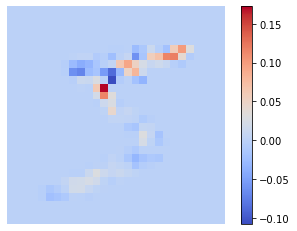

In [10]:
# 5) Explain an Instance
intgrad_tf_score = ig.explain(image, 5, 'black', preprocessing, predict, model_type='tensorflow')

plt.imshow(intgrad_tf_score.reshape(28,28), cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## Intgrad (PyTorch Model)

In [11]:
# Load Dataset
#import torchvision
#import torchvision.datasets as datasets
#mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
#mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)
#from tensorflow.keras.datasets import mnist
#(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()

# Load the model
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.softmax(self.linear_block(x),dim=1)
        
        return x
MNIST_CNN = Net()
MNIST_CNN.load_state_dict(torch.load('./models/MNIST_Pytorch_CNN.pt',map_location=torch.device('cpu')))
MNIST_CNN.eval()

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


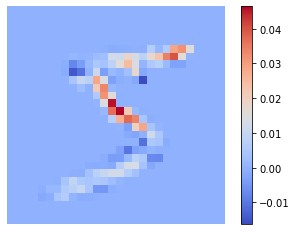

In [12]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(MNIST_CNN)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
image = MNIST_x_data_train[idx]

# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return torch.tensor([[image/255]]).float()

# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return MNIST_CNN(image)

# 5) Explain an Instance
intgrad_pt_score = ig.explain(image, 5, 'black', preprocessing, predict, model_type='pytorch').reshape(28,28)

plt.imshow(intgrad_pt_score,cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## LIME

In [9]:
!pip install lime

     |████████████████████████████████| 275 kB 5.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=dd724b70215cc833aa61fef61b0577efd1280a3f826040a89628b8f0898283f0
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


<img src='https://github.com/francescanaretto/XAI-course_2021/blob/main/Images/images/lime_MNIST.jpg?raw=1' width="50%" height="50%">

100%|██████████| 500/500 [00:00<00:00, 565.35it/s]


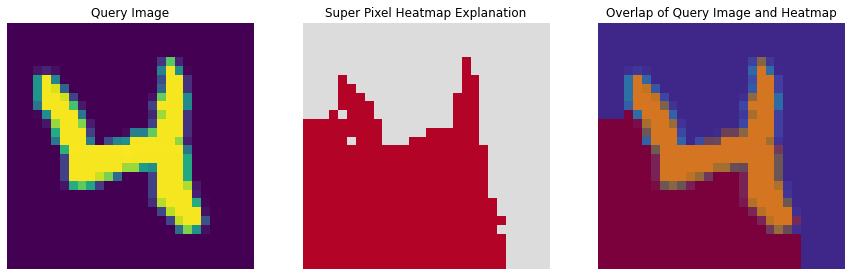

In [60]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# index of the image to explain
idx = 20

# 1) Create the Explainer
lm = LimeXAIImageExplainer(MNIST_CNN)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = torch.tensor(rgb2gray(images/255).reshape(-1,1,28,28)).float()
    return np.argmax(MNIST_CNN(images).detach().numpy(),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(gray2rgb(MNIST_x_data_train[idx]), classifier_fn, num_samples=500)

# 4) Plot the results
lm.plot_lime_values(MNIST_x_data_train[idx], explanation)

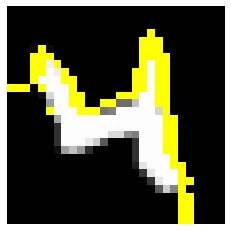

In [61]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
plt.axis('off');

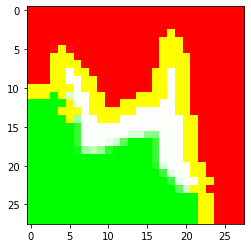

In [62]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2);

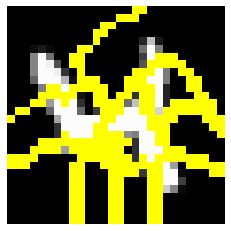

In [63]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb
image = gray2rgb(MNIST_x_data_train[idx].astype(int))
"""
First you need to define the segmentation function to use, in this example we will use
quickshift from skimage. It is foundamental to tune the parameters of the segmentation in
order to have a good one. It is recommentded to print an example of just only the segmentation
to see if it works for that kind of image
For quickshift we have to tune these two parameters below
kernel_size : float, optional
    Width of Gaussian kernel used in smoothing the
    sample density. Higher means fewer clusters.
max_dist : float, optional
    Cut-off point for data distances.
    Higher means fewer clusters.
"""
def segmentation_fn(image):
    return quickshift(image, kernel_size=2, max_dist=3)
plt.imshow(mark_boundaries(image/255,segmentation_fn(image)))
plt.axis('off');

100%|██████████| 500/500 [00:00<00:00, 529.54it/s]


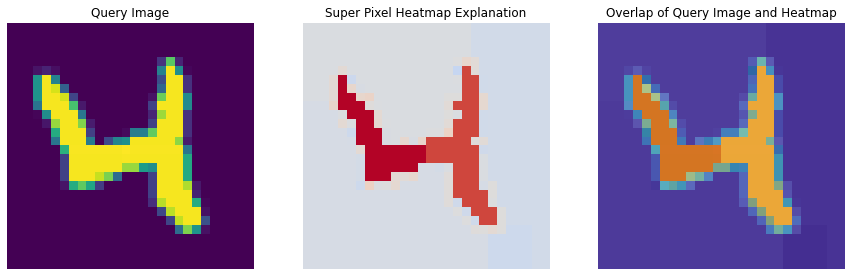

In [64]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# index of the image to explain
idx = 20

# 1) Create the Explainer
lm = LimeXAIImageExplainer(MNIST_CNN)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = torch.tensor(rgb2gray(images/255).reshape(-1,1,28,28)).float()
    return np.argmax(MNIST_CNN(images).detach().numpy(),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(gray2rgb(MNIST_x_data_train[idx]), classifier_fn, segmentation_fn, num_samples=500)

# 4) Plot the results
lm.plot_lime_values(MNIST_x_data_train[idx], explanation)

In [65]:
lime_score = explanation.heatmap

## RISE

<img src='https://github.com/francescanaretto/XAI-course_2021/blob/main/Images/images/rise_MNIST.jpg?raw=1' width="50%" height="50%">

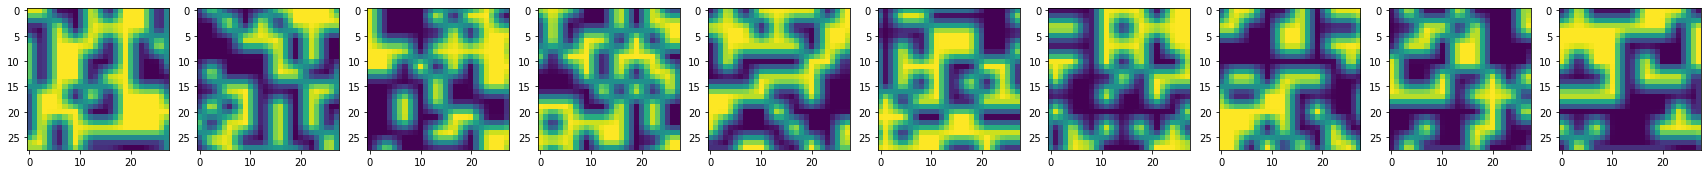

In [66]:
from xailib.explainers.rise_explainer import RiseXAIImageExplainer

class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size
        
    def predict(self, X):
        return self.model(torch.tensor(X).reshape(-1,1,28,28).float()/255).detach().numpy()
        

model = Rise_model_wrapper(MNIST_CNN, (28,28))
rise = RiseXAIImageExplainer(model)
        

N = 10 # number of random masks
s = 10 # cell_size = input_shape / s
p1 = 0.5 # masking probability

rise.fit(N, s, p1)

F,ax=plt.subplots(1,10,figsize=(30,5))
for i in range(10):
    ax[i].imshow(rise.masks[i,:].reshape(28,28))

(10, 28, 28)


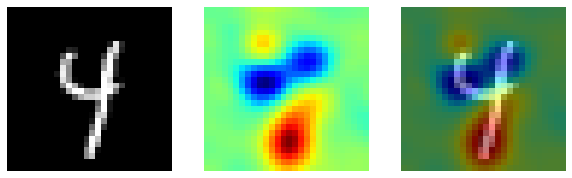

In [17]:
fig, ax = plt.subplots(1,3,figsize=(10,5))
img = MNIST_x_data_train[26,:]
N = 4000
s = 8
p1 = 0.5

rise.fit(N, s, p1)

sal = rise.explain(img.reshape(28,28,1)/255)
print(sal.shape)
rise_score = sal[MNIST_y_data_test[0]]

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(rise_score,cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(rise_score,cmap='jet',alpha=0.5)
ax[2].axis('off');

# GRADCAM
Weight the 2D activations by the average gradient

In [18]:
!pip install ttach

In [19]:
from xailib.explainers.gradcam_explainer import GradCAMImageExplainer

img = MNIST_x_data_train[26,:]

explainer = GradCAMImageExplainer(MNIST_CNN)

explainer.fit([MNIST_CNN.conv_block[10]])

attr = explainer.explain(torch.tensor(img).reshape(-1,1,28,28).float()/255, 5, model_type='pytorch')
gradcam_pt_score = attr[0,:]

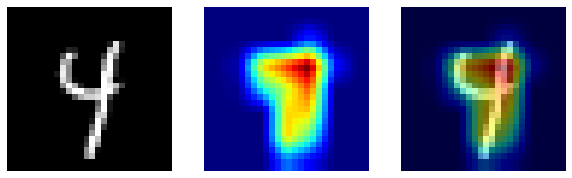

In [20]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

In [21]:
from xailib.explainers.gradcam_explainer import GradCAMImageExplainer

img = MNIST_x_data_train[26,:]

explainer = GradCAMImageExplainer(MNIST_CNN_tf)

explainer.fit('max_pooling2d_1', model_type='tensorflow')

attr = explainer.explain(tf.convert_to_tensor(img.reshape(28,28,1)/255,dtype=tf.float32), 5, model_type='tensorflow')
gradcam_tf_score = attr

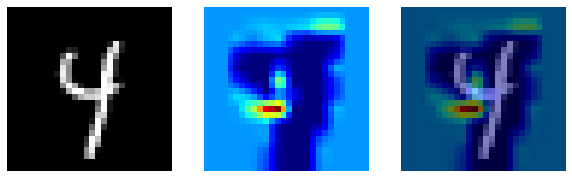

In [22]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr,cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr,cmap='jet',alpha=0.5)
ax[2].axis('off');

# GRADCAM++
Like GradCAM but uses second order gradients

In [23]:
from xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer

img = MNIST_x_data_train[26,:]

explainer = GradCAMPlusPlusImageExplainer(MNIST_CNN)

explainer.fit([MNIST_CNN.conv_block[10]])

attr = explainer.explain(torch.tensor(img).reshape(-1,1,28,28).float()/255, 5, model_type='pytorch')
gradcampp_pt_score = attr[0,:]

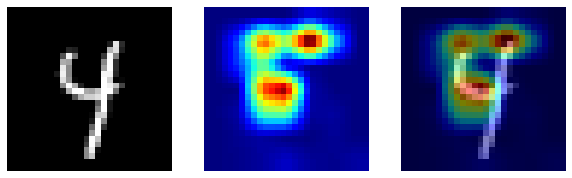

In [24]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

In [25]:
from xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer

img = MNIST_x_data_train[26,:]

explainer = GradCAMPlusPlusImageExplainer(MNIST_CNN_tf)

explainer.fit('max_pooling2d_1', model_type='tensorflow')

attr = explainer.explain(tf.convert_to_tensor(img.reshape(28,28,1)/255,dtype=tf.float32), 5, model_type='tensorflow')
gradcampp_tf_score = attr

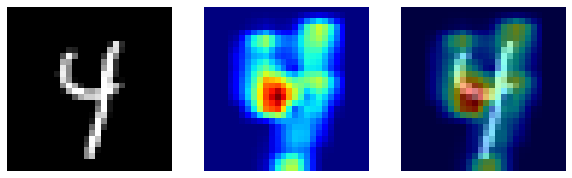

In [26]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr,cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr,cmap='jet',alpha=0.5)
ax[2].axis('off');

# ILORE

In [27]:
!pip install bitarray deap

     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 160 kB 32.6 MB/s 
  Created wheel for bitarray: filename=bitarray-2.3.5-cp37-cp37m-linux_x86_64.whl size=171996 sha256=9c72b760f68bf4bff4ab050bb9c9464f0fa39c8f52af966d3fdb0b2c788aebc0
  Stored in directory: /root/.cache/pip/wheels/78/3f/c2/51401246e3e827137d0ea8fac1ce14508400f4a8f5e50d919a
Successfully built bitarray


<img src='https://github.com/francescanaretto/XAI-course_2021/blob/main/Images/images/lore_MNIST.jpg?raw=1' width="50%" height="50%">

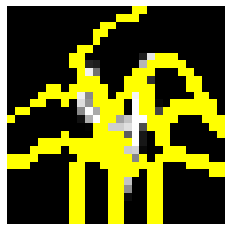

In [28]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb
image = gray2rgb(MNIST_x_data_train[26].astype(int))
"""
First you need to define the segmentation function to use, in this example we will use
quickshift from skimage. It is foundamental to tune the parameters of the segmentation in
order to have a good one. It is recommentded to print an example of just only the segmentation
to see if it works for that kind of image
For quickshift we have to tune these two parameters below
kernel_size : float, optional
    Width of Gaussian kernel used in smoothing the
    sample density. Higher means fewer clusters.
max_dist : float, optional
    Cut-off point for data distances.
    Higher means fewer clusters.
"""
def segmentation_fn(image):
    return quickshift(image, kernel_size=2, max_dist=3)
plt.imshow(mark_boundaries(image/255,segmentation_fn(image)))
plt.axis('off');

In [29]:
from externals.LOREM.ilorem import ILOREM

# Function to convert from rgb2gray since the one implemented in skimage gives problems
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

# Predict Function of our black box. 
# !!!IMPORTANT!!! It needs to take as input a list of RGB images and return an array of class indices of shape (-1,1)
def classifier_fn(images):
    images = torch.tensor(rgb2gray(np.array(images))/255).float().unsqueeze(1)
    return np.argmax(MNIST_CNN(images).detach().numpy(),axis=1).reshape(-1,1)

# Create the explainer
explainer = ILOREM(bb_predict = classifier_fn, 
                   class_name='class', 
                   class_values = range(10), 
                   segmentation_fn=segmentation_fn,
                   verbose=True)

In [30]:
exp = explainer.explain_instance(gray2rgb(MNIST_x_data_train[26].astype(int)), num_samples=100, use_weights=True, metric='cosine')

generating neighborhood
synthetic neighborhood class counts {1: 20, 4: 90}
learning local decision tree
retrieving explanation


In [31]:
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))

e = {
	r = { 3 > 0.50, 9 > 0.50 } --> { class: 4 }
	c = { { 3 <= 0.50, 4 <= 0.50, 0 <= 0.50 } --> { class: 1 } }    
}


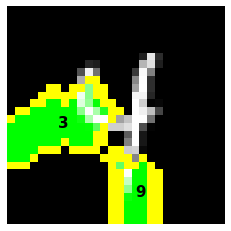

In [32]:
x,y = np.meshgrid(range(28),range(28))
img2show, mask = exp.get_image_rule(hide_rest=False, num_features=None, min_importance=0.0)
plt.imshow(mark_boundaries(img2show/255,mask))
mask[mask != 2] = -1
mask[mask == 2] = segmentation_fn(image)[mask == 2]

mask = mask.ravel()

for i in np.unique(mask):
    if i != -1:
        x_c = x.ravel()[np.where(mask==i)[0]]
        y_c = y.ravel()[np.where(mask==i)[0]]
        plt.text(np.median(x_c),np.median(y_c),str(i),fontsize=15, weight='bold')
plt.axis('off');

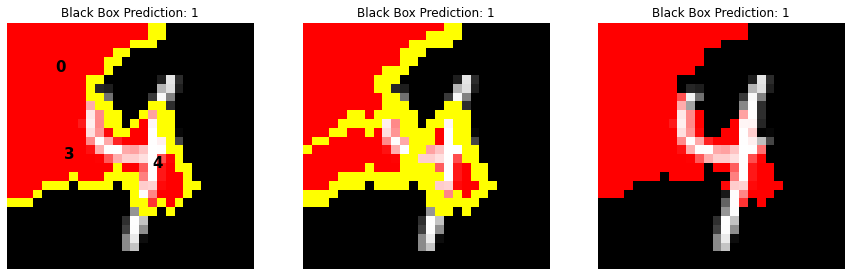

In [33]:
imgs2show, masks, coutcomes = exp.get_image_counterfactuals(hide_rest=False, num_features=None, min_importance=0.0)
x,y = np.meshgrid(range(28),range(28))
s = segmentation_fn(image)

if len(imgs2show)==1:
    plt.imshow(mark_boundaries(imgs2show[0]/255, masks[0]))
    
    mask = masks[0]
    mask[mask != 1] = -1
    mask[mask == 1] = s[mask == 1]
    mask = mask.ravel()
    for j in np.unique(mask):
        if j != -1:
            x_c = x.ravel()[np.where(mask==j)[0]]
            y_c = y.ravel()[np.where(mask==j)[0]]
            plt.text(np.median(x_c),np.median(y_c),str(j),fontsize=15, weight='bold')
            
    plt.title('Black Box Prediction: '+str(coutcomes[0]))
    plt.axis('off')
else:
    F, ax = plt.subplots(1,len(imgs2show),figsize=(5*len(imgs2show),5))
    for i in range(len(imgs2show)):
        ax[i].imshow(mark_boundaries(imgs2show[i]/255, masks[i]))
        
        mask = masks[i]
        mask[mask != 1] = -1
        mask[mask == 1] = s[mask == 1]
        mask = mask.ravel()
        for j in np.unique(mask):
            if j != -1:
                x_c = x.ravel()[np.where(mask==j)[0]]
                y_c = y.ravel()[np.where(mask==j)[0]]
                ax[i].text(np.median(x_c),np.median(y_c),str(j),fontsize=15, weight='bold')
        
        ax[i].set_title('Black Box Prediction: '+str(coutcomes[i]))
        ax[i].axis('off')

# ABELE

In order to work ABELE needs a Test Set and an autoencoder trained on that

### 1) Autoencoder Training

Here we have a script to guide the user to the creation and the training of the autoencoder. 
If you want to use your own, you need to implement an autoencoder class with these funtioncs inside:
- self.encode: take the image as input and return the latent space vector
- self.decode: take a vector as input and return the reconstructed image
- self.latent_dim: int representing the number of dimensions of the latent space
- self.discriminator: (only for adversarial autoencoders) take a vector as input and output a class label

In [34]:
import sys
import os
import skimage
from externals.ABELE.experiments.exputil import get_autoencoder
from externals.ABELE.experiments.exputil import get_dataset
import warnings
warnings.filterwarnings('ignore')

#disable eager execution in tensorflow 2.x for faster training time
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# The dataset to use for training
# if you prefer to use yours load the data in two vector X_data and Y_data, set dataset variable to a custom name and custom_dataset to True
dataset = 'mnist'
custom_dataset = False
if not custom_dataset:
    X_train, Y_train, X_test, Y_test, use_rgb = get_dataset(dataset)

# The type of autoencoder to train ['aae','vae']
ae_name = 'aae'

# This script will save the models weights in the folder ./path/models/abele/dataset/ae_name
path = './'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
if not os.path.exists(path_aemodels):
    os.makedirs(path_aemodels)

# HYPER-PARAMETERS
#define the epochs and the batch size for which the autoencoder will be trained
epochs = 2000
batch_size = 64
#Print training summary every sample_interval step
sample_interval = 50

"""
 Get_autoencoder create the autoencoder class to train
 Arguments: 
    X: dataset to use to train the ae 
    ae_name: type of the autoencoder to train, only adversarial autoencoder (aae) and variational autoencoder (vae) are supported
    path_aemodels: path where to save the weights
    dataset: name of the dataset to use
    OPTIONAL:
    latent_dim: latent space dimension (only use if dataset is custom)
    hidden_dim: hidden dimension of the autoencoders layers (ex: 1024 will create two layers of 1024 hidden units) (only use if dataset is custom)
    num_filters: number of filter to use in the convolutional layers (only use if dataset is custom)
"""
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset)

""" Fit method
 Arguments: 
    X: Dataset to use to train the ae
    epochs: Epochs to train
    batch_size
    sample interval (see before)
"""
#ae.fit(X_test, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
# save the weights in the oath specified before
#ae.save_model()
# save also some sample images to test if the autoencoderis trained correctly
#ae.sample_images(epochs)

' Fit method\n Arguments: \n    X: Dataset to use to train the ae\n    epochs: Epochs to train\n    batch_size\n    sample interval (see before)\n'

In [35]:
ae.load_model()

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	75    	0.496654	0.496654	0.496654
1  	48    	0.52987 	0.0720791	0.993207
2  	53    	0.612624	0.119984 	0.99321 
3  	34    	0.784104	0.237382 	0.993253
4  	43    	0.902329	0.208538 	0.993253
5  	55    	0.931783	0.305789 	0.993281
6  	28    	0.963306	0.320577 	0.993281
7  	37    	0.952561	0.087079 	0.993281
8  	46    	0.9712  	0.348339 	0.993281
9  	46    	0.977858	0.433642 	0.993281
10 	40    	0.951185	0.208965 	0.993284
11 	46    	0.960549	0.244741 	0.993284
12 	43    	0.971094	0.411205 	0.993284
13 	42    	0.96764 	0.402916 	0.993284
14 	44    	0.991886	0.934963 	0.993284
15 	42    	0.94733 	0.290485 	0.993284
16 	42    	0.947224	0.439413 	0.993299
17 	46    	0.945432	0.421335 	0.993299
18 	52    	0.957023	0.443587 	0.993299
19 	45    	0.953778	0.245319 	0.9933  
20 	42    	0.959758	0.0414952	0.9933  
21 	44    	0.983758	0.285066 	0.9933  
22 	39    	0.99294 	0.966404 	0.9933  
23 	47    	0.985183	0.404797 	0.9933

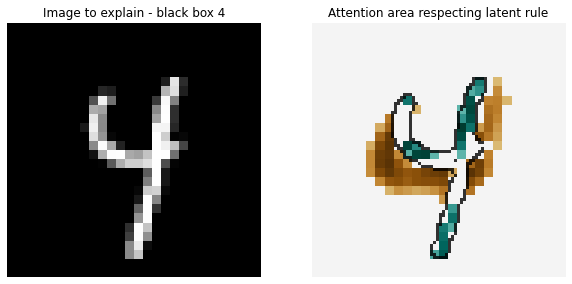

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform

from xailib.explainers.abele_explainer import ABELEImageExplainer
from externals.ABELE.experiments.exputil import get_dataset
from externals.ABELE.experiments.exputil import get_autoencoder

import warnings
warnings.filterwarnings('ignore')

random_state = 0
dataset = 'mnist' 
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae' 
path = './' 
path_aemodels = path + 'models/abele/%s/%s/' % (dataset, ae_name)
#bb = tf.keras.models.load_model("./models/cnn_simple_mnist_no_pickle")
bb = MNIST_CNN

# defining a functions for bb to return the class index value
def bb_predict(image):
    return np.argmax(MNIST_CNN(torch.tensor(rgb2gray(image/255).reshape(-1,1,28,28)).float()).detach().numpy(),axis=1)
#def bb_predict(X):
#    X = X.astype(float)
#    Y = bb.predict(rgb2gray(X).reshape(-1,28,28,1))   
#    return np.argmax(Y, axis=1)

# load data
_, _, X_test, Y_test, _ = get_dataset(dataset)

# load auto encoder
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset)
ae.load_model()

# index Image 2 Explain
i2e = 26
img = X_train[i2e]
# time
start = time.time()

# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(Y_test)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':ae, 
          'use_rgb':True, 
          'filter_crules':True, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':100, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}


explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain(img, num_samples=300, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.getRules(), exp.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp.exp.bb_pred,'dt prediction: ',exp.exp.dt_pred,'fidelity: ',exp.exp.fidelity)
print('latent space representation: ',exp.exp.limg)

"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.getFeaturesImportance(features=None, samples=400)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

Green Points are the ones critical for the prediction, also called exemplars

Yellow points are the ones who change class if activated

White Points are do-nothing points

In [37]:
abele_score = mask

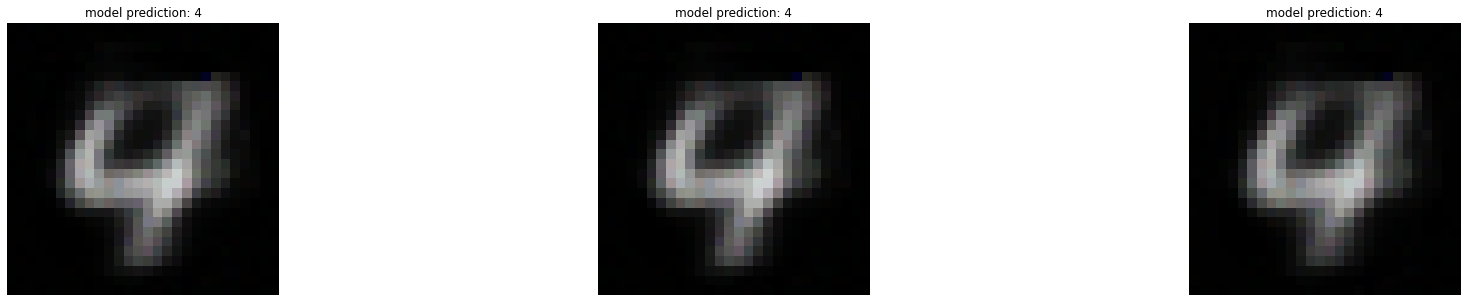

In [39]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5] number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features int he latent space to use, if none use all
"""
proto = exp.getExemplars(num_prototypes=5)

F, ax = plt.subplots(1,len(proto),figsize=(30,5))
for i in range(len(proto)):
    ax[i].imshow(proto[i]/255)
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(proto[i])[0]))

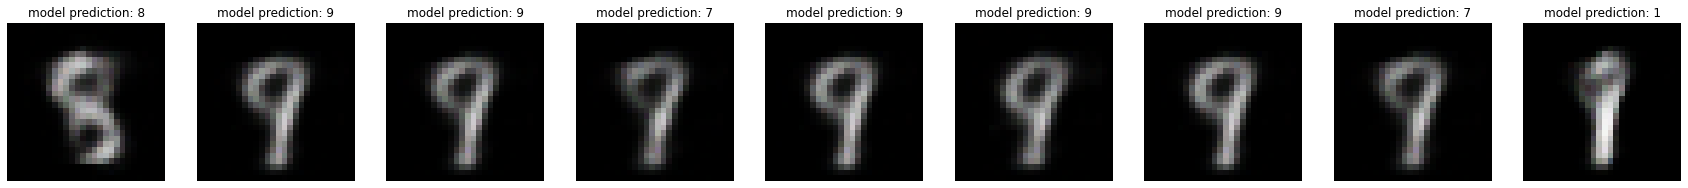

In [40]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.getCounterExemplars()

F, ax = plt.subplots(1,len(counter),figsize=(30,5))
for i in range(len(counter)):
    ax[i].imshow(counter[i]/255)
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(counter[i])[0]))

# Metrics

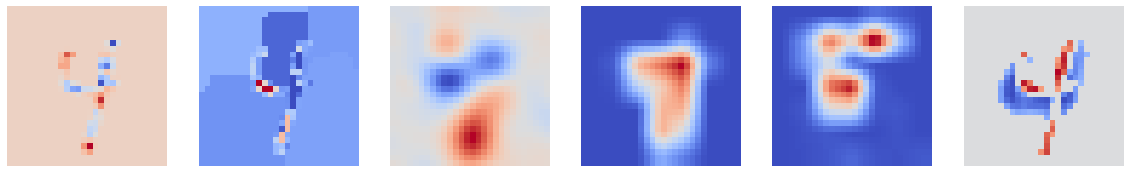

In [41]:
methods = [intgrad_pt_score,lime_score,rise_score,gradcam_pt_score,gradcampp_pt_score,abele_score]
F, ax = plt.subplots(1,6,figsize=(20,5))
for i in range(6):
    ax[i].axis(False)
    ax[i].imshow(methods[i],cmap='coolwarm')

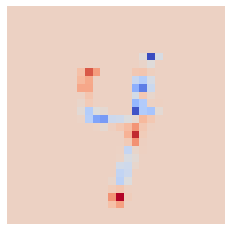

In [42]:
image = MNIST_x_data_train[0:1]
plt.imshow(intgrad_pt_score,cmap='coolwarm')
plt.axis(False);

In [43]:
from xailib.metrics.insertiondeletion import ImageInsDel
import torch

# Load the model
# MNIST_CNN

def predict(image):
    return MNIST_CNN(torch.tensor(image.reshape(1,1,28,28)/255).float()).detach().numpy()

step = 28
mode = 'del'
metric = ImageInsDel(predict, mode, step, torch.zeros_like)

Score: 0.8720068254525747


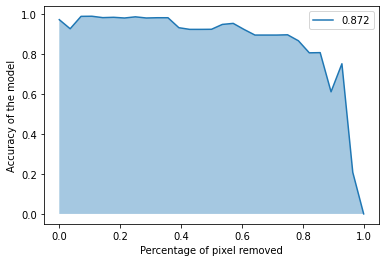

In [44]:
from sklearn.metrics import auc

y = metric(image, 28, intgrad_pt_score, rgb=False)
x = np.arange(len(y))*step/784
x[-1] = 1.0
print('Score:', auc(x, y))

plt.plot(x, y, label=np.round(auc(x, y),4))
plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend();

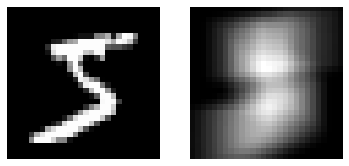

In [45]:
from scipy.ndimage.filters import gaussian_filter
CH = 1
def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen//2, klen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((CH, CH, klen, klen))
    for i in range(CH):
        kern[i, i] = k
    return torch.from_numpy(kern.astype('float32'))

# Function that blurs input image
def blur(image, klen=11, ksig=5):

    kern = gkern(klen, ksig)
    image = torch.tensor(np.expand_dims(image, 0)).float()
    return nn.functional.conv2d(image, kern, padding=klen//2)[0,:]

F,ax = plt.subplots(1,2)
ax[0].imshow(image[0,:], cmap='gray')
ax[0].axis(False)
ax[1].imshow(blur(image)[0,:],cmap='gray')
ax[1].axis(False);

In [46]:
from xailib.metrics.insertiondeletion import ImageInsDel

def predict(image):
    return MNIST_CNN(torch.tensor(image.reshape(1,1,28,28)/255).float()).detach().numpy()

step = 10
mode = 'ins'
metric = ImageInsDel(predict, mode, step, blur)

Score: 0.2451196580837785


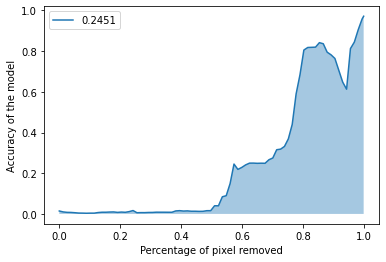

In [47]:
from sklearn.metrics import auc

y = metric(image, 28, intgrad_pt_score, rgb=False)
x = np.arange(len(y))*step/784
x[-1] = 1.0
print('Score:', auc(x, y))

plt.plot(x, y, label=np.round(auc(x, y),4))
plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend();

class 8: probability 0.592
class 1: probability 0.151


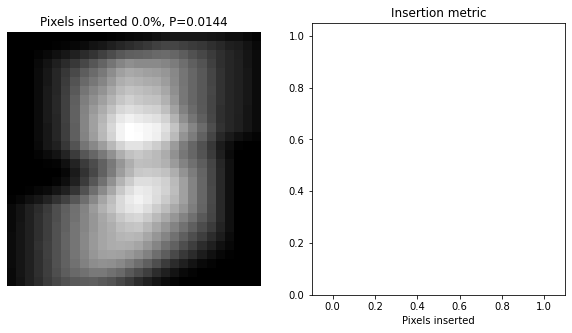

class 8: probability 0.771
class 0: probability 0.055


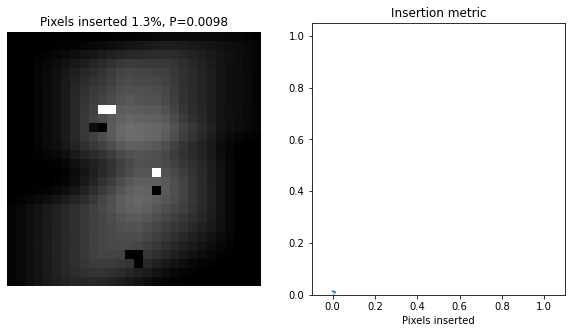

class 8: probability 0.835
class 9: probability 0.038


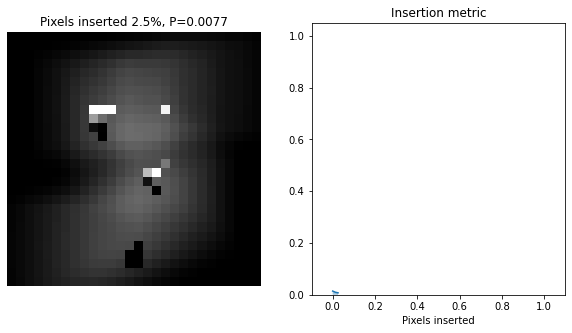

class 8: probability 0.858
class 0: probability 0.036


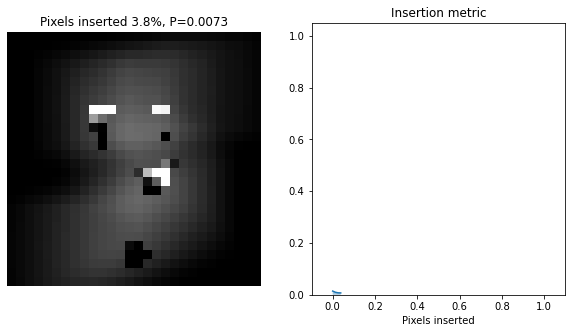

class 8: probability 0.883
class 0: probability 0.032


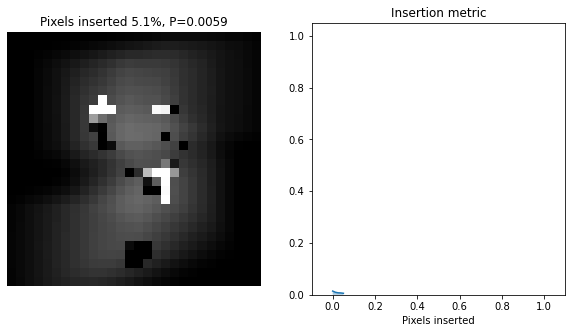

class 8: probability 0.911
class 0: probability 0.023


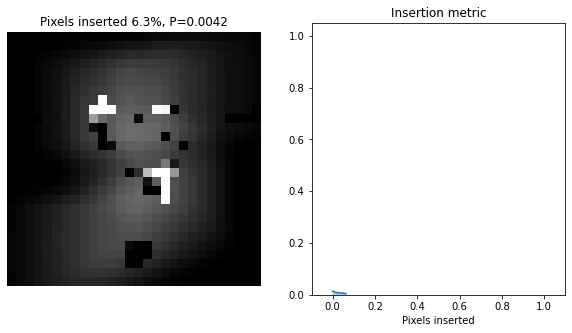

class 8: probability 0.925
class 0: probability 0.019


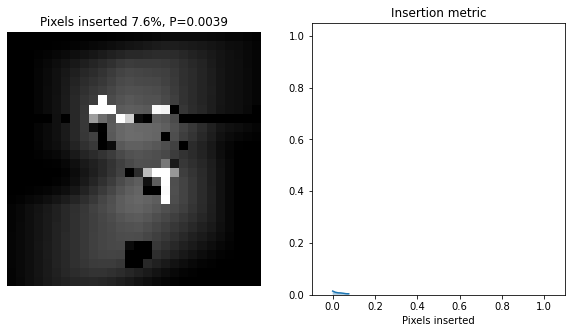

class 8: probability 0.931
class 9: probability 0.017


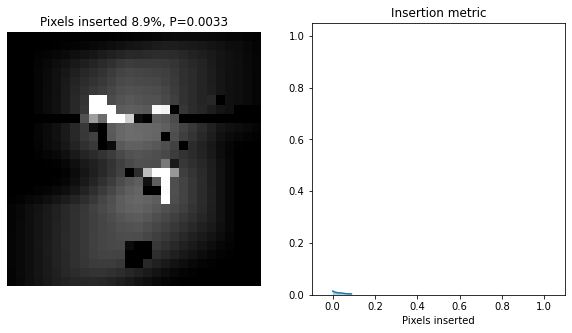

class 8: probability 0.899
class 9: probability 0.028


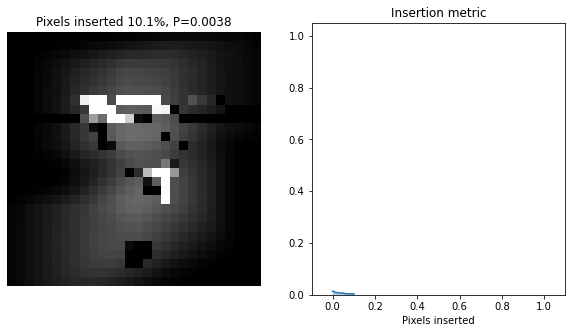

class 8: probability 0.899
class 9: probability 0.028


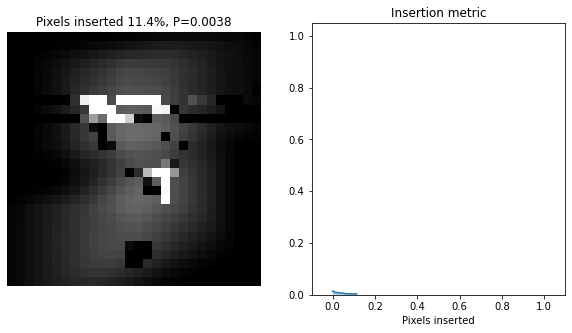

class 8: probability 0.878
class 9: probability 0.033


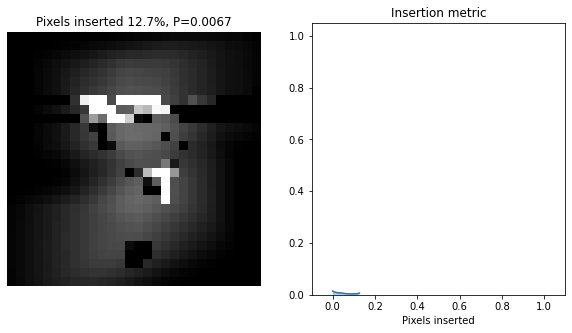

class 8: probability 0.848
class 9: probability 0.046


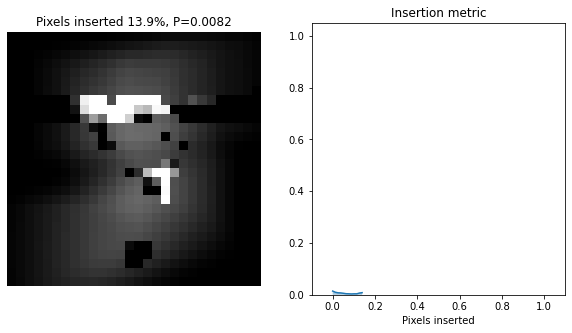

class 8: probability 0.863
class 9: probability 0.038


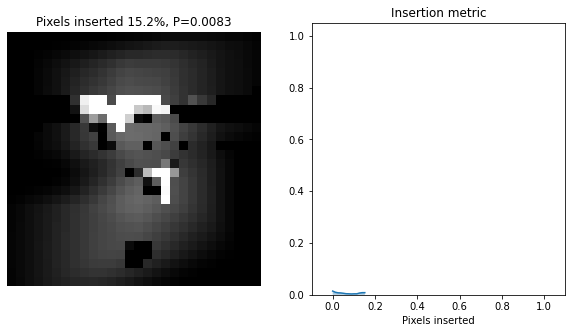

class 8: probability 0.874
class 9: probability 0.034


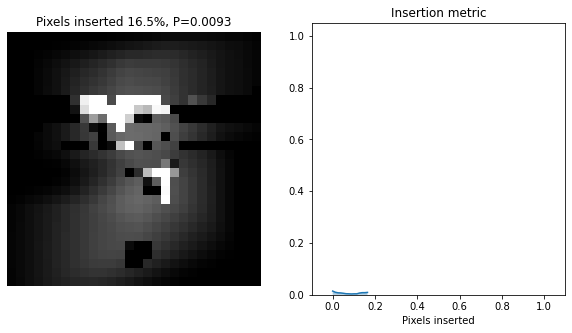

class 8: probability 0.870
class 9: probability 0.034


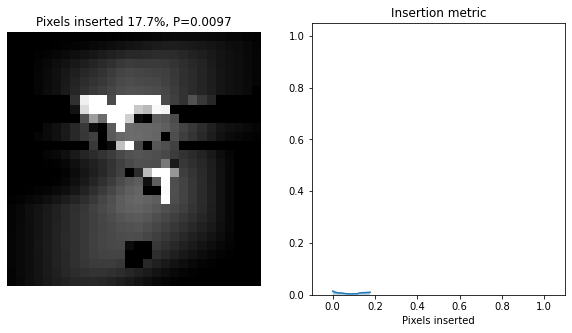

class 8: probability 0.915
class 9: probability 0.025


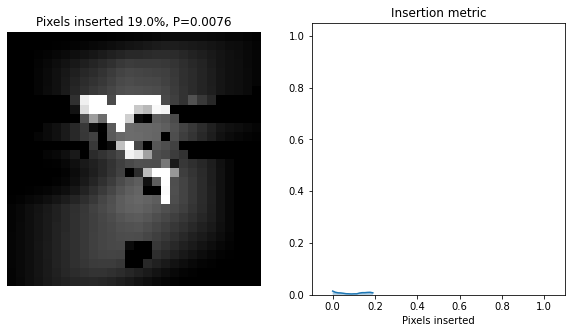

class 8: probability 0.902
class 9: probability 0.027


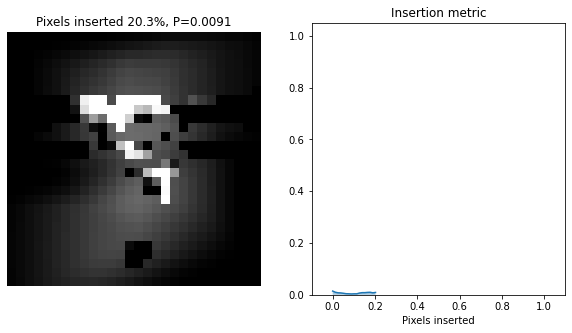

class 8: probability 0.903
class 9: probability 0.031


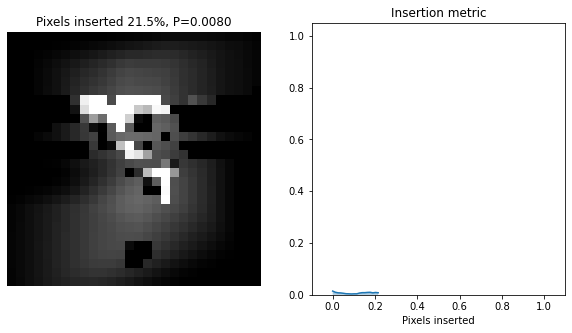

class 8: probability 0.868
class 9: probability 0.040


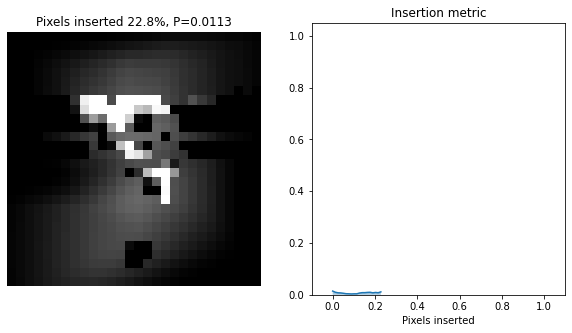

class 8: probability 0.823
class 9: probability 0.052


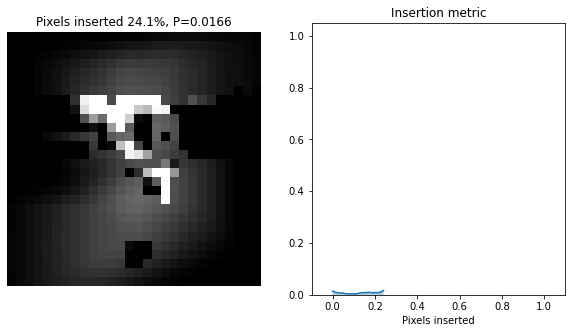

class 8: probability 0.926
class 9: probability 0.033


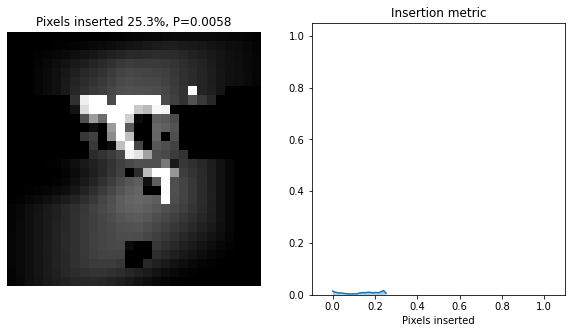

class 8: probability 0.920
class 9: probability 0.036


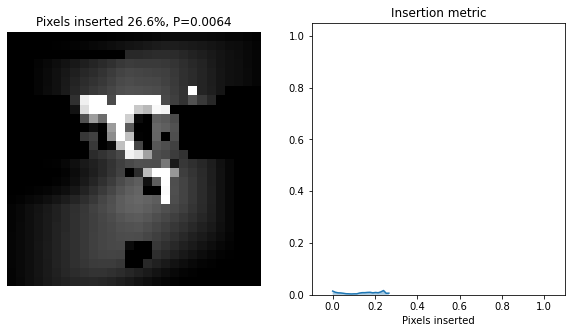

class 8: probability 0.921
class 9: probability 0.036


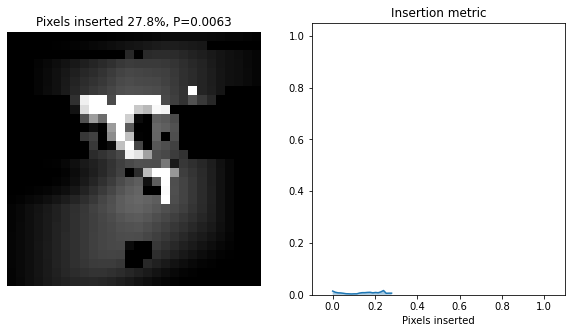

class 8: probability 0.917
class 9: probability 0.038


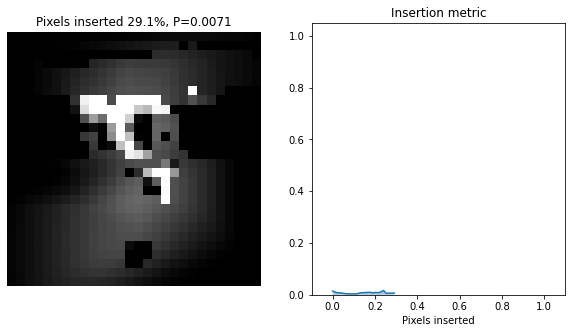

class 8: probability 0.918
class 9: probability 0.037


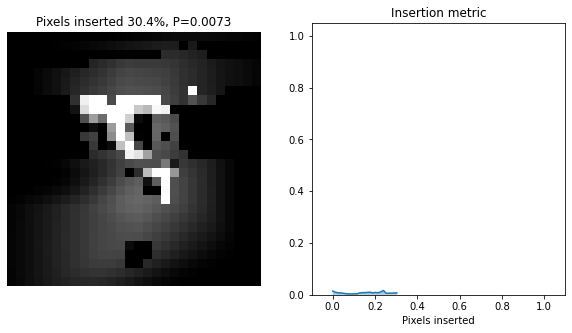

class 8: probability 0.915
class 9: probability 0.038


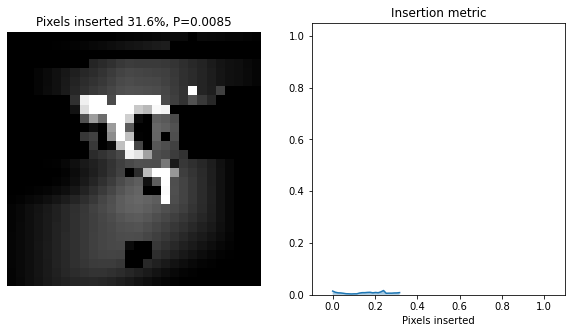

class 8: probability 0.915
class 9: probability 0.037


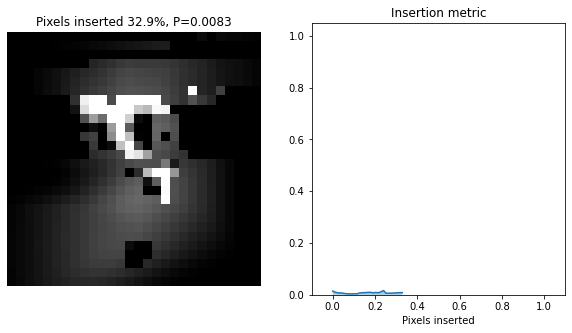

class 8: probability 0.915
class 9: probability 0.037


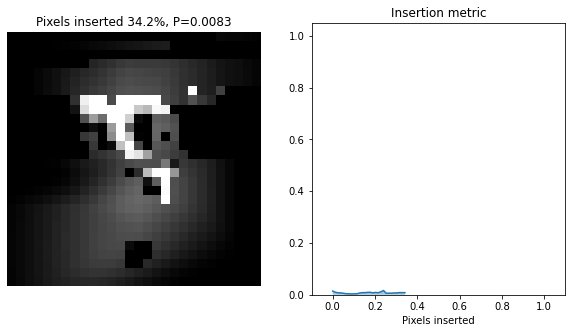

class 8: probability 0.914
class 9: probability 0.040


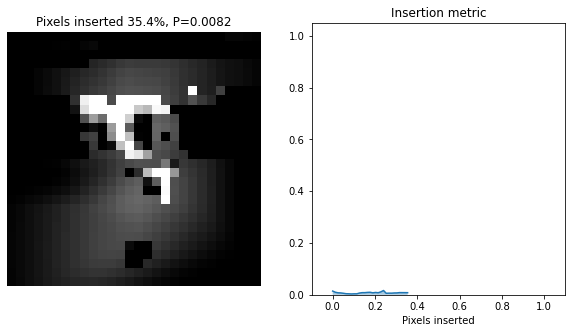

class 8: probability 0.914
class 9: probability 0.040


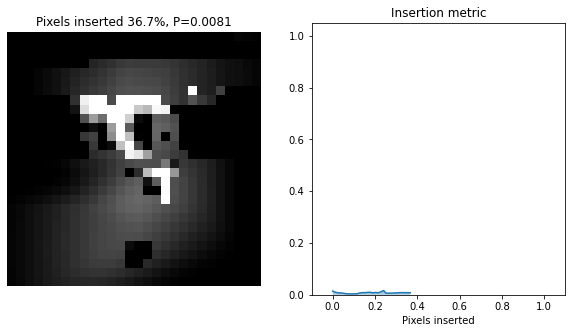

class 8: probability 0.902
class 9: probability 0.042


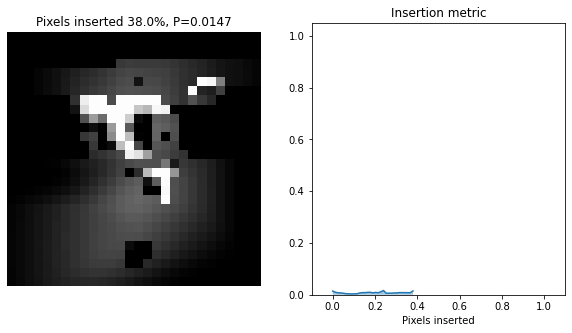

class 8: probability 0.896
class 9: probability 0.048


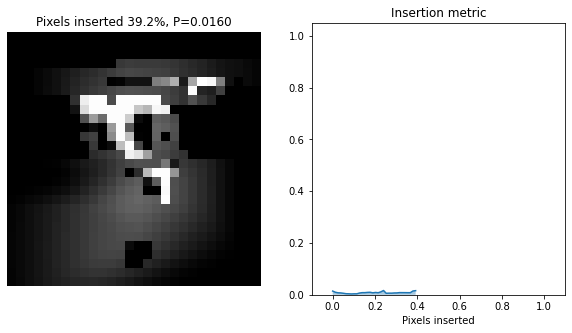

class 8: probability 0.899
class 9: probability 0.047


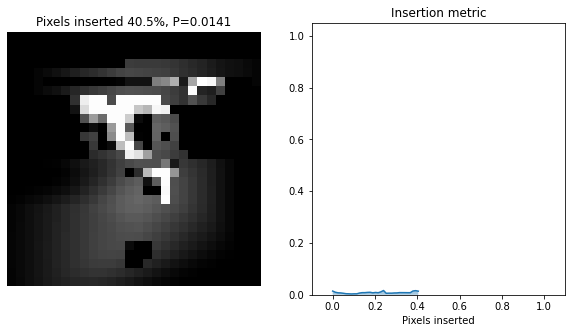

class 8: probability 0.909
class 9: probability 0.044


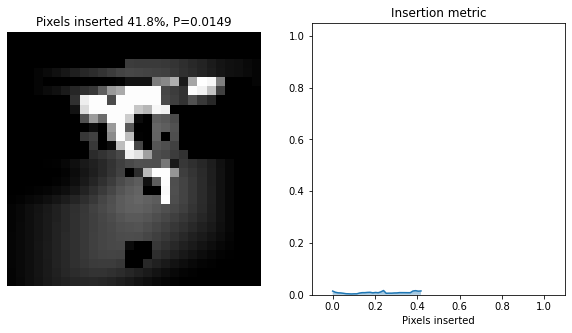

class 8: probability 0.913
class 9: probability 0.043


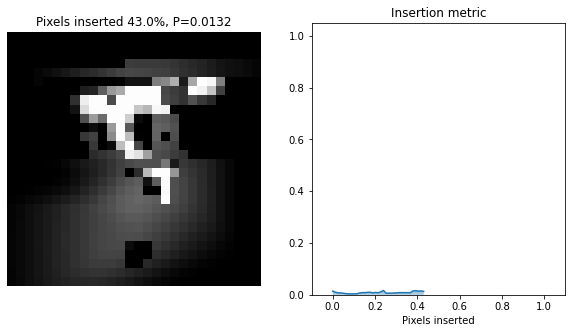

class 8: probability 0.914
class 9: probability 0.043


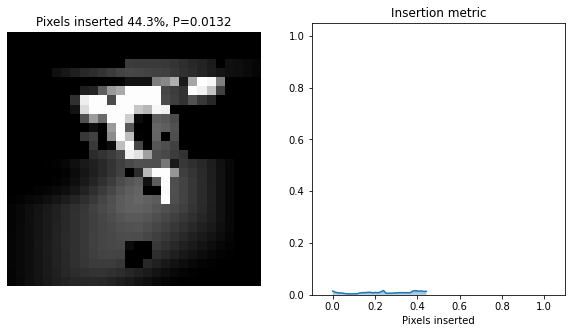

class 8: probability 0.923
class 9: probability 0.038


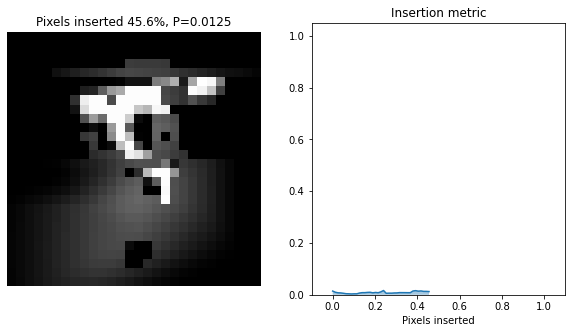

class 8: probability 0.924
class 9: probability 0.040


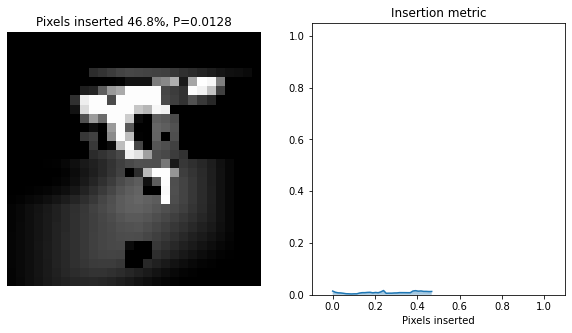

class 8: probability 0.914
class 9: probability 0.044


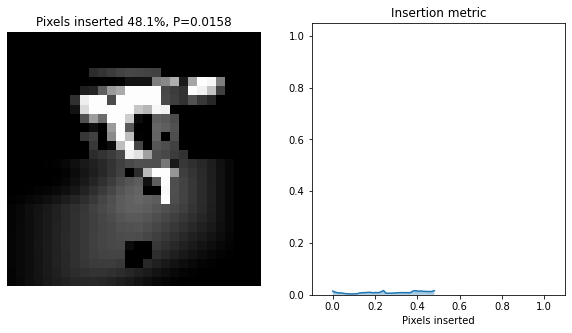

class 8: probability 0.904
class 9: probability 0.054


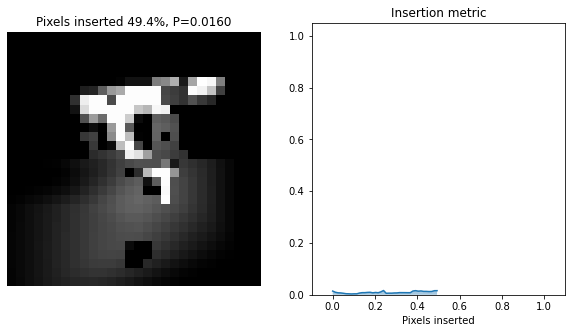

class 8: probability 0.854
class 9: probability 0.060


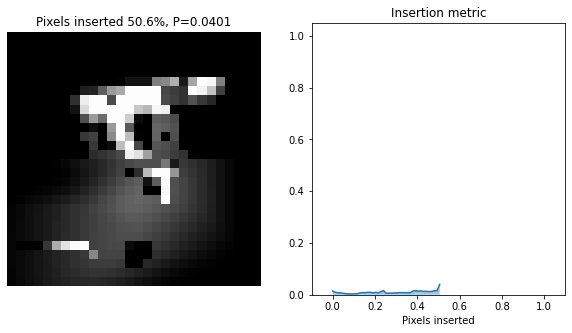

class 8: probability 0.856
class 9: probability 0.055


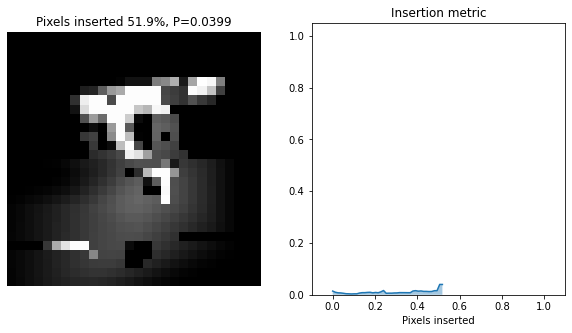

class 8: probability 0.754
class 5: probability 0.084


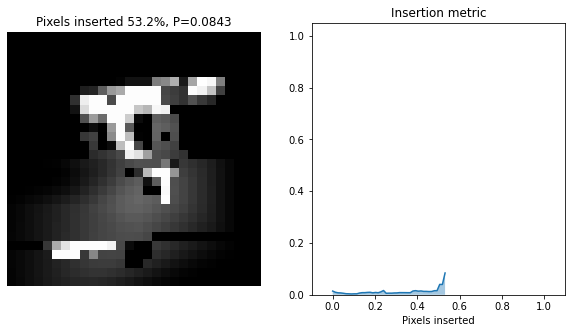

class 8: probability 0.741
class 5: probability 0.090


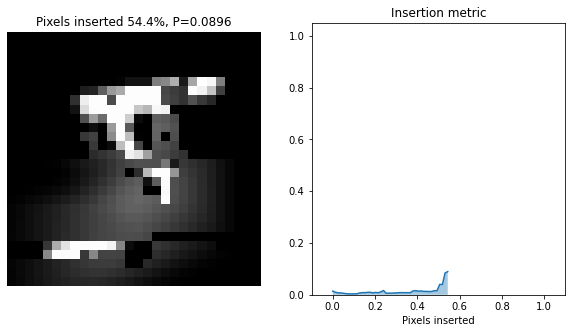

class 8: probability 0.556
class 5: probability 0.149


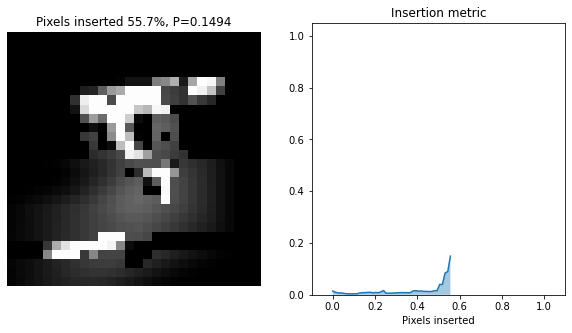

class 8: probability 0.411
class 5: probability 0.245


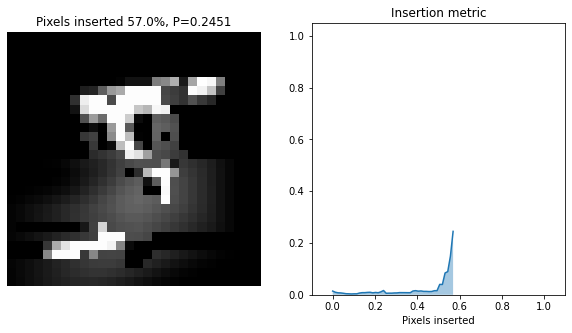

class 8: probability 0.419
class 5: probability 0.219


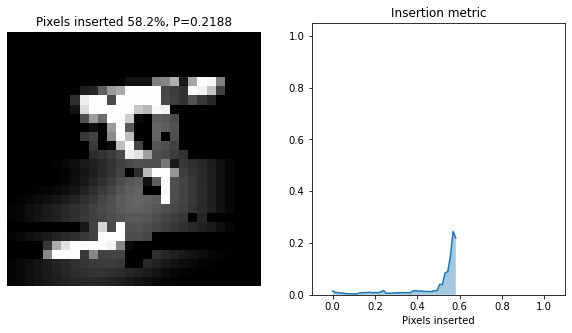

class 8: probability 0.316
class 9: probability 0.248


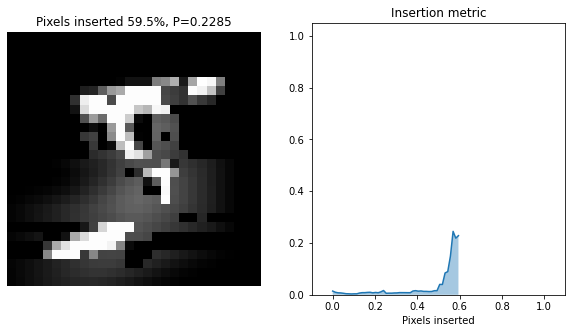

class 8: probability 0.313
class 5: probability 0.241


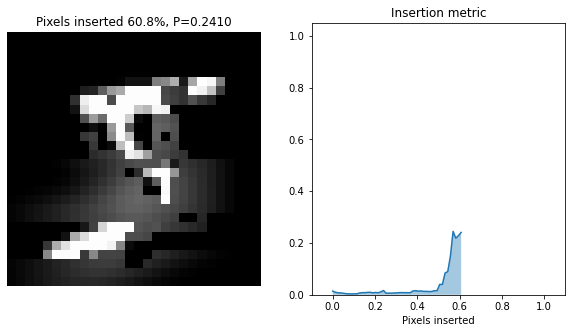

class 8: probability 0.285
class 5: probability 0.250


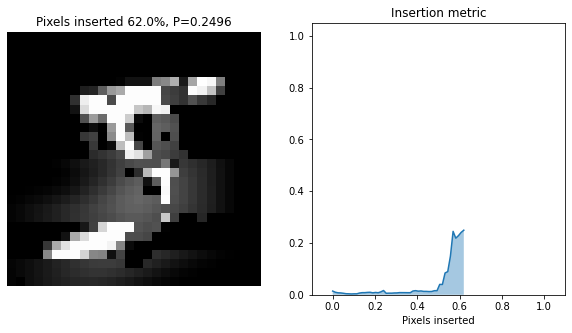

class 8: probability 0.285
class 5: probability 0.250


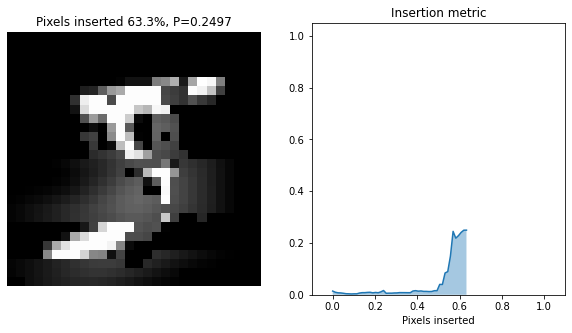

class 8: probability 0.283
class 5: probability 0.249


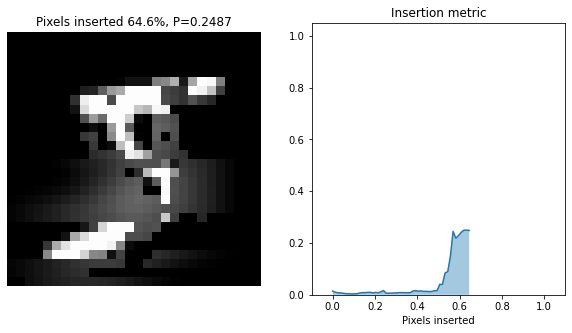

class 8: probability 0.283
class 5: probability 0.249


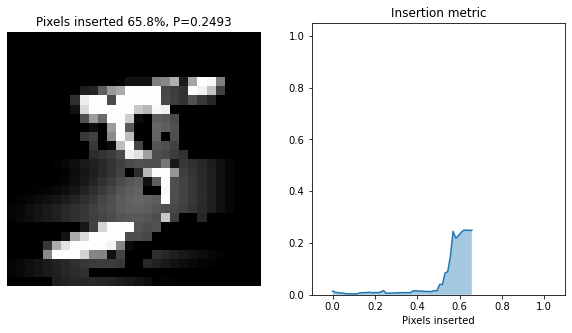

class 8: probability 0.284
class 5: probability 0.249


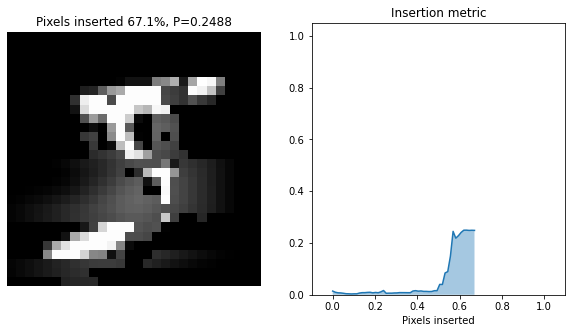

class 8: probability 0.295
class 5: probability 0.266


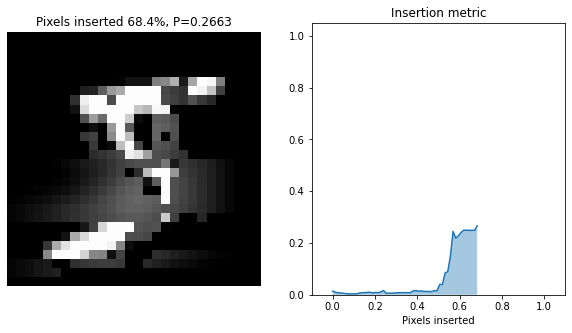

class 8: probability 0.307
class 5: probability 0.275


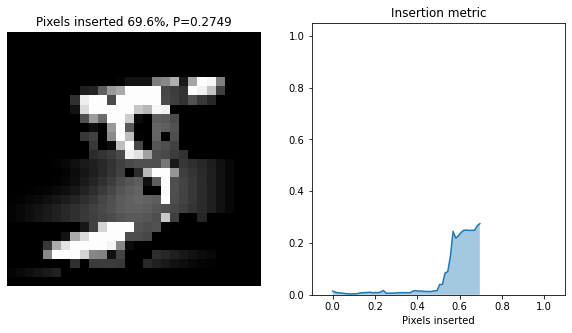

class 5: probability 0.316
class 8: probability 0.283


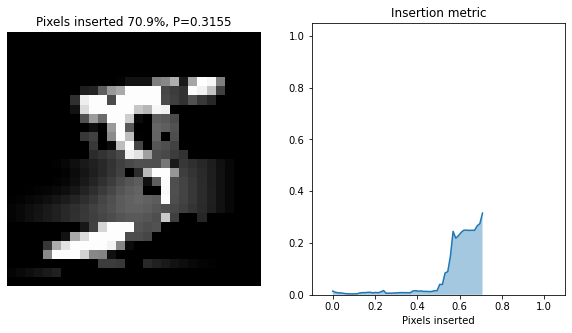

class 5: probability 0.318
class 8: probability 0.286


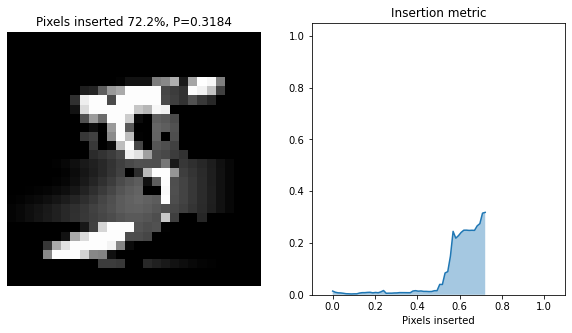

class 5: probability 0.332
class 8: probability 0.294


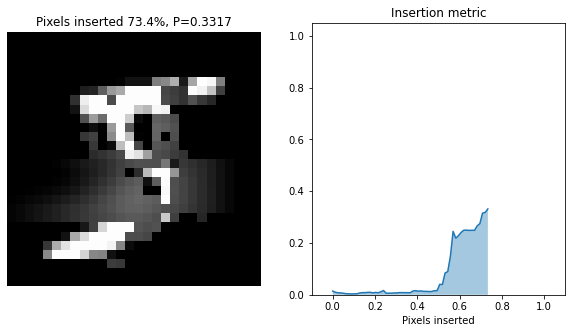

class 5: probability 0.369
class 8: probability 0.291


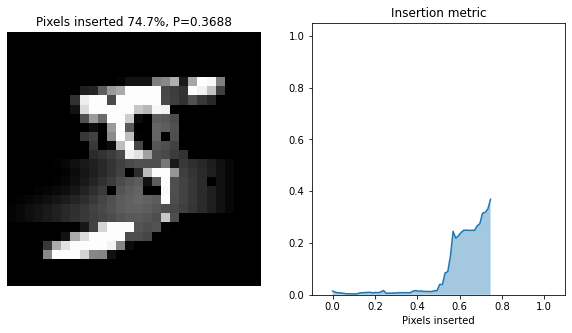

class 5: probability 0.440
class 3: probability 0.227


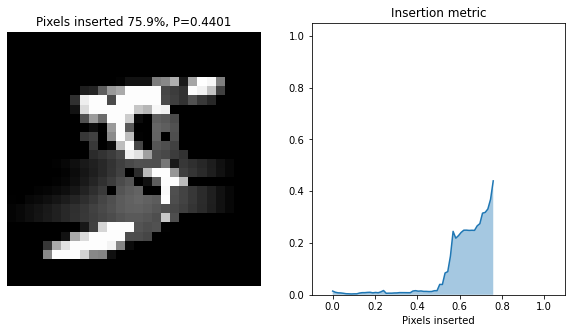

class 5: probability 0.590
class 3: probability 0.236


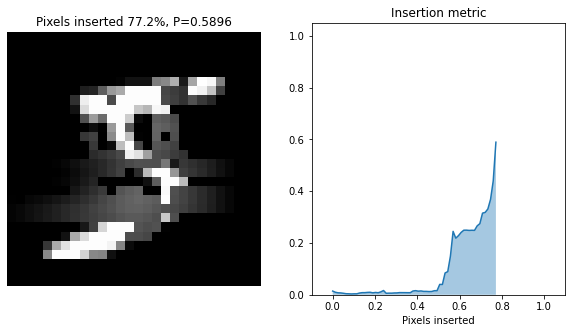

class 5: probability 0.684
class 3: probability 0.215


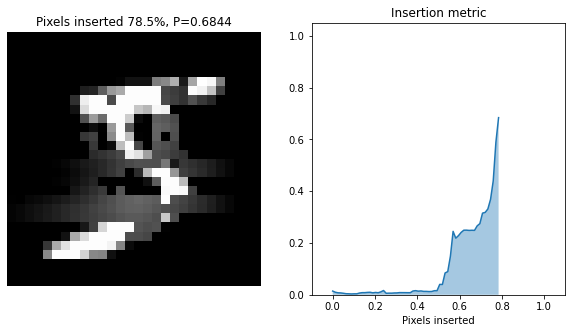

class 5: probability 0.806
class 3: probability 0.141


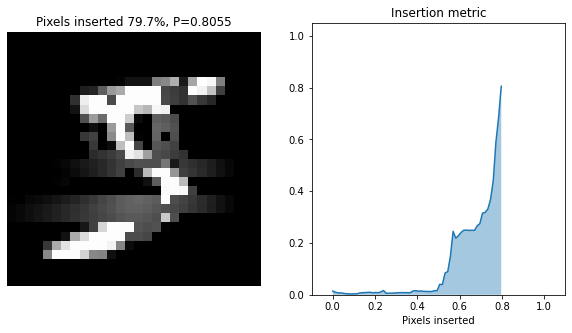

class 5: probability 0.818
class 3: probability 0.132


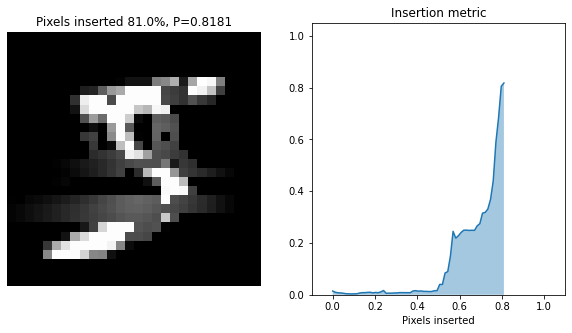

class 5: probability 0.819
class 3: probability 0.134


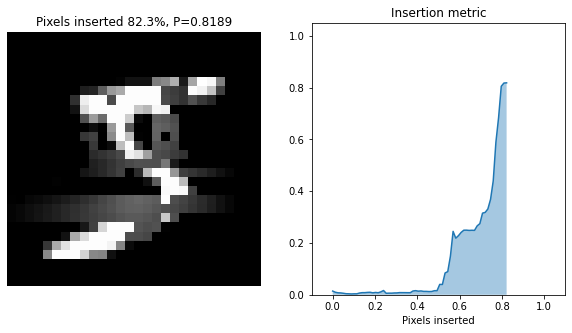

class 5: probability 0.820
class 3: probability 0.133


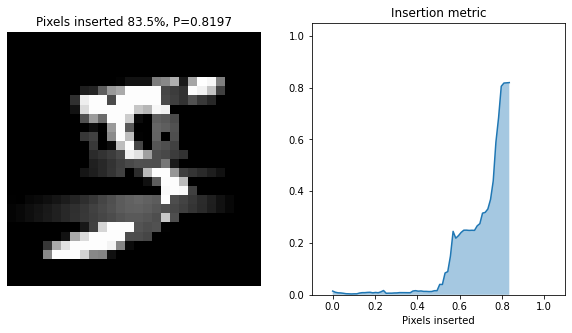

class 5: probability 0.842
class 3: probability 0.117


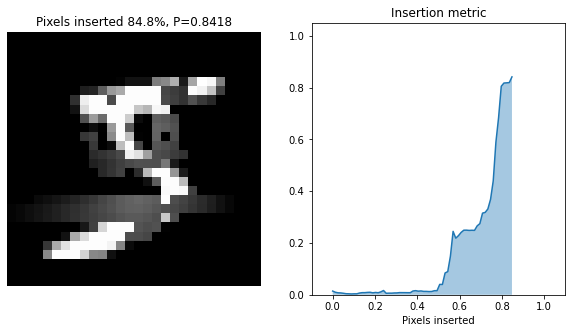

class 5: probability 0.836
class 3: probability 0.124


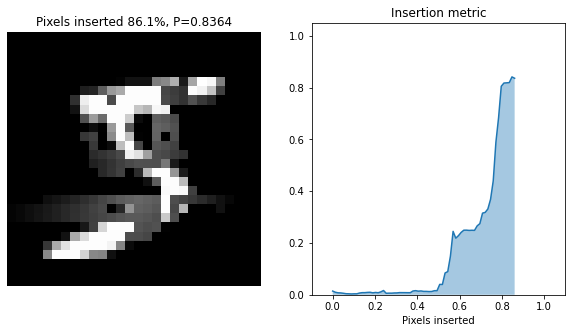

class 5: probability 0.795
class 3: probability 0.151


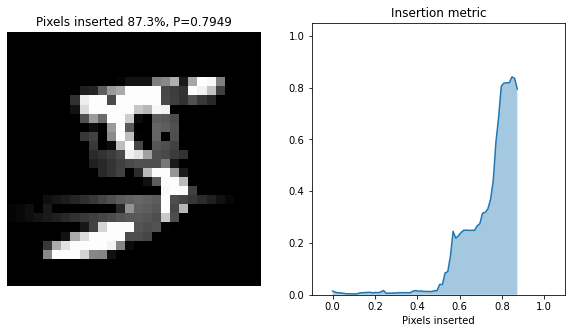

class 5: probability 0.782
class 3: probability 0.156


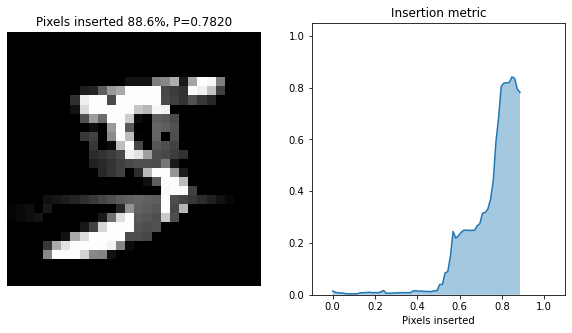

class 5: probability 0.764
class 3: probability 0.167


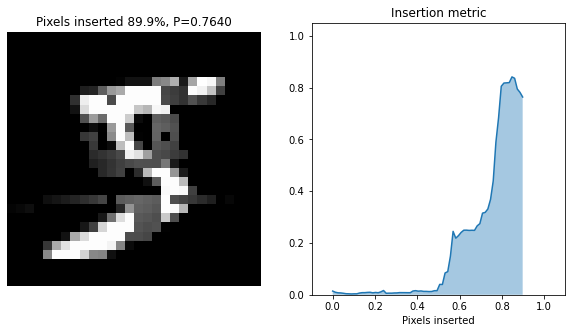

class 5: probability 0.706
class 3: probability 0.211


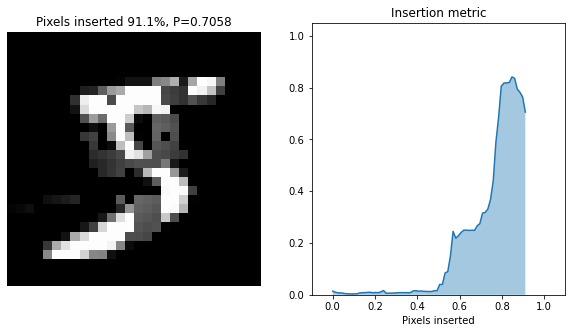

class 5: probability 0.648
class 3: probability 0.243


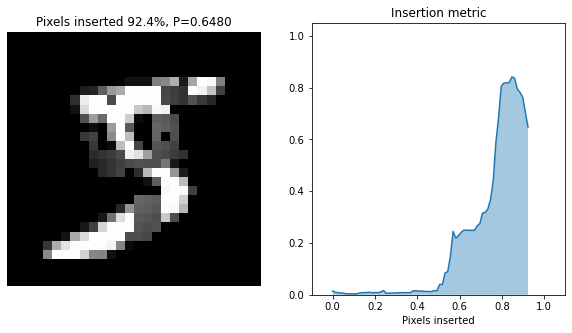

class 5: probability 0.613
class 3: probability 0.317


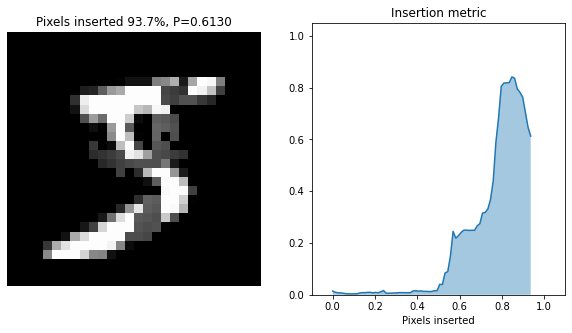

class 5: probability 0.813
class 3: probability 0.157


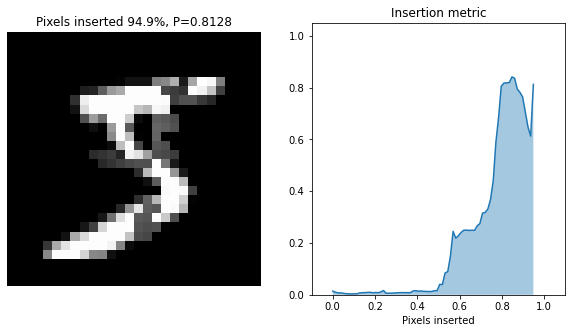

class 5: probability 0.845
class 3: probability 0.131


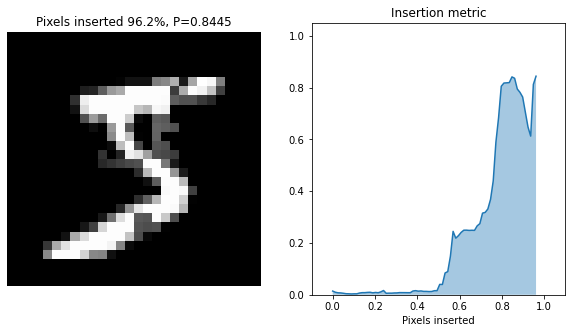

class 5: probability 0.905
class 3: probability 0.081


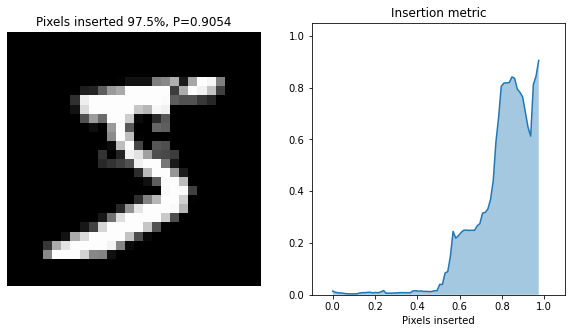

class 5: probability 0.958
class 3: probability 0.036


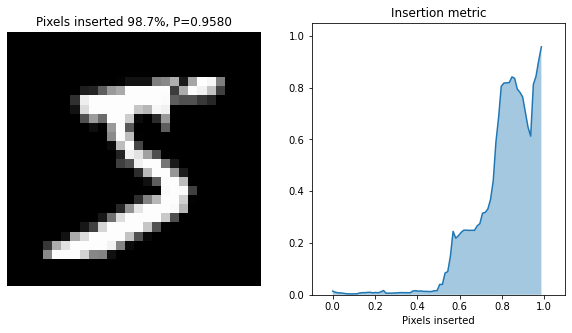

class 5: probability 0.972
class 3: probability 0.024


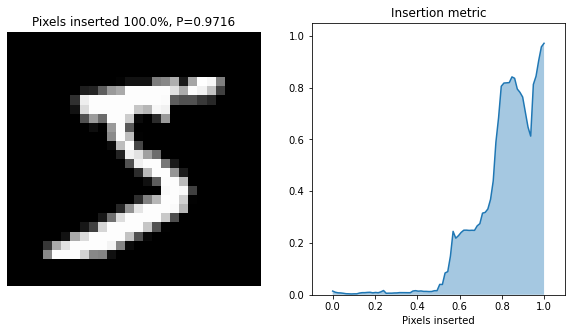

In [48]:
y = metric(image, 28, intgrad_pt_score, rgb=False, verbose=2)

In [49]:
names = ['intgrad','lime','rise','gradcam','gradcam++','abele']
scores = [intgrad_pt_score,lime_score,rise_score,gradcam_pt_score,gradcampp_pt_score,abele_score]
step = 28
mode = 'del'
metric = ImageInsDel(predict, mode, step, torch.zeros_like)
print('Deletion Scores')
for i in range(len(scores)):
    y = metric(image, 28, scores[i], rgb=False)
    x = np.arange(len(y))*step/784
    x[-1] = 1.0
    print(f'{names[i]}: {auc(x, y)}')


Deletion Scores
intgrad: 0.8720068254525747
lime: 0.8777371957782765
rise: 0.7156737896631447
gradcam: 0.3071079504516093
gradcam++: 0.2799365437053245
abele: 0.7116331197264246


In [50]:
names = ['intgrad','lime','rise','gradcam','gradcam++','abele']
scores = [intgrad_pt_score,lime_score,rise_score,gradcam_pt_score,gradcampp_pt_score,abele_score]
step = 28
mode = 'ins'
metric = ImageInsDel(predict, mode, step, blur)
print('Insertion Scores')
for i in range(len(scores)):
    y = metric(image, 28, scores[i], rgb=False)
    x = np.arange(len(y))*step/784
    x[-1] = 1.0
    print(f'{names[i]}: {auc(x, y)}')


Insertion Scores
intgrad: 0.24552641315884624
lime: 0.340654371106731
rise: 0.2096674862716879
gradcam: 0.6962618794142535
gradcam++: 0.5184781683741936
abele: 0.2506233244452492
